In [1]:
import numpy as np
import os
import pandas as pd
from keras import layers
from keras import backend as K
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf

In [6]:
train_df = pd.read_csv('/content/fashion-mnist_train.csv',sep=',')
test_df = pd.read_csv('/content/fashion-mnist_test.csv', sep = ',')

In [7]:
from sklearn.model_selection import train_test_split
X_full = train_df.iloc[:,1:]
y_full = train_df.iloc[:,:1]
x_train, x_test, y_train, y_test = train_test_split(X_full, y_full, test_size
= 0.3)

In [8]:
x_train = x_train.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
y_train = y_train.values.astype('int')
y_test = y_test.values.astype('int')
print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

Training (42000, 28, 28, 1) 1.0
Testing (18000, 28, 28, 1) 1.0


In [9]:
# reorganize by groups
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [4200, 4173, 4186, 4214, 4209, 4171, 4189, 4227, 4189, 4242]
test groups: [1800, 1827, 1814, 1786, 1791, 1829, 1811, 1773, 1811, 1758]


In [10]:
def gen_random_batch(in_groups, batch_halfsize = 8):
  out_img_a, out_img_b, out_score = [], [], []
  all_groups = list(range(len(in_groups)))
  for match_group in [True, False]:
    group_idx = np.random.choice(all_groups, size = batch_halfsize)
    out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
    if match_group:
      b_group_idx = group_idx
      out_score += [1]*batch_halfsize
    else:
      # anything but the same group
      non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx]
      b_group_idx = non_group_idx
      out_score += [0]*batch_halfsize

    out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]

    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)


In [38]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [37]:
import keras
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [39]:
input_layer = Input(shape=(224, 224, 3))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(10, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(10, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(10, activation='softmax', name='output')(x)

In [13]:
model = Model(inputs=input_layer, outputs=x)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs = 4, batch_size = 16, validation_split = 0.2, verbose = 1, steps_per_epoch = 500,)

Epoch 1/4
500/500 [==============================] - 326s 637ms/step - loss: 1.1759 - accuracy: 0.5683 - val_loss: 2.9004 - val_accuracy: 0.1902
Epoch 2/4
500/500 [==============================] - 311s 623ms/step - loss: 0.7475 - accuracy: 0.7237 - val_loss: 0.5585 - val_accuracy: 0.7977
Epoch 3/4
500/500 [==============================] - 311s 623ms/step - loss: 0.6145 - accuracy: 0.7795 - val_loss: 0.5324 - val_accuracy: 0.8139
Epoch 4/4
500/500 [==============================] - 311s 622ms/step - loss: 0.5546 - accuracy: 0.7971 - val_loss: 0.5773 - val_accuracy: 0.7780


In [15]:
from keras.layers import concatenate
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout

img_a_in = Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = Input(shape = x_train.shape[1:], name = 'ImageB_Input')
img_a_feat = model(img_a_in)
img_b_feat = model(img_b_in)
combined_features = concatenate([img_a_feat, img_b_feat], name =
'merge_features')
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = Model(inputs = [img_a_in, img_b_in], outputs =
[combined_features], name = 'Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 10)           1196146     ['ImageA_Input[0][0]',           
                                                                  'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 20)           0           ['model[0][0]',   

In [27]:
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy',
metrics = ['acc'])


In [28]:
# make a generator out of the data
def siam_gen(in_groups, batch_size = 32):
 while True:
    pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
    yield [pv_a, pv_b], pv_sim

valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit_generator(siam_gen(train_groups), steps_per_epoch = 500, validation_data=([valid_a, valid_b],valid_sim), epochs = 4, verbose = True)

Epoch 1/4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


500/500 [==============================] - 566s 1s/step - loss: 0.3818 - acc: 0.9317 - val_loss: 0.3626 - val_acc: 1.0000
Epoch 2/4
500/500 [==============================] - 555s 1s/step - loss: 0.0865 - acc: 1.0000 - val_loss: 0.2511 - val_acc: 1.0000
Epoch 3/4
500/500 [==============================] - 544s 1s/step - loss: 0.0323 - acc: 1.0000 - val_loss: 0.0184 - val_acc: 1.0000
Epoch 4/4
500/500 [==============================] - 547s 1s/step - loss: 0.0118 - acc: 1.0000 - val_loss: 0.0084 - val_acc: 1.0000


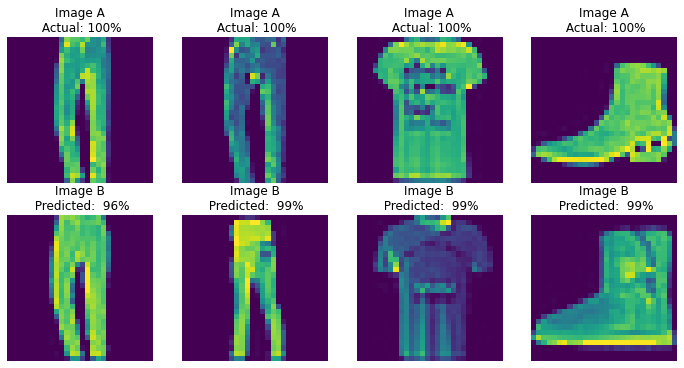

In [29]:
_ = show_model_output(4)

In [30]:
%%time
from sklearn.manifold import TSNE
x_test_features = model.predict(x_test, verbose = True, batch_size=128)

tsne_obj = TSNE(n_components=2,
    init='pca',
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=1)
tsne_features = tsne_obj.fit_transform(x_test_features)

141/141 [==============================] - 119s 843ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18000 samples in 0.026s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 18000 samples in 0.554s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18000
[t-SNE] Computed conditional probabilities for sample 2000 / 18000
[t-SNE] Computed conditional probabilities for sample 3000 / 18000
[t-SNE] Computed conditional probabilities for sample 4000 / 18000
[t-SNE] Computed conditional probabilities for sample 5000 / 18000
[t-SNE] Computed conditional probabilities for sample 6000 / 18000
[t-SNE] Computed conditional probabilities for sample 7000 / 18000
[t-SNE] Computed conditional probabilities for sample 8000 / 18000
[t-SNE] Computed conditional probabilities for sample 9000 / 18000
[t-SNE] Computed conditional probabilities for sample 10000 / 18000
[t-SNE] Computed conditional probabilities for sample 11000 / 18000
[t-SNE] Computed conditional probabilities for sample 12000 / 18000
[t-SNE] Computed conditional probabilities for sample 13000 / 18000
[t-SNE] Computed conditional probabilities for sample 14000 / 18000

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.216667
[t-SNE] KL divergence after 500 iterations: 1.373068
CPU times: user 6min 1s, sys: 4.81 s, total: 6min 5s
Wall time: 3min 22s


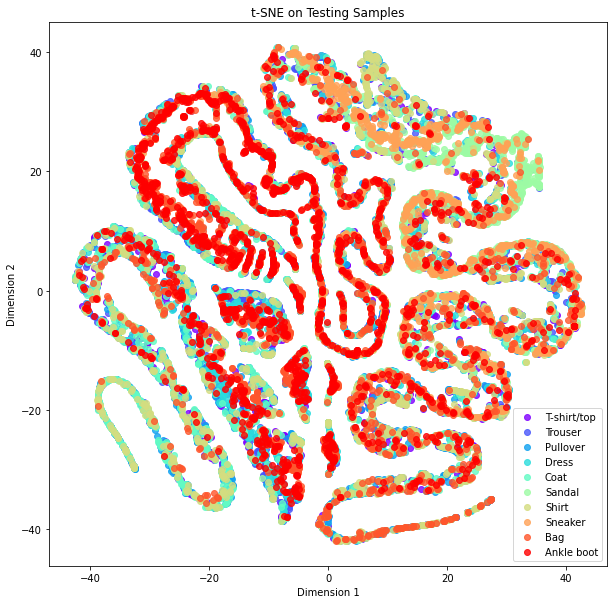

In [31]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
 'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
 plt.scatter(tsne_features[np.where(y_test == c_group), 0],
 tsne_features[np.where(y_test == c_group), 1],
 marker='o',
 color=c_color,
 linewidth='1',
 alpha=0.8,
 label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)
